# Titanic survival analysis and prediction
This project is related to the kaggle compition found [here](https://www.kaggle.com/c/titanic)  
And is heavily infulenced by this [notebook](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

In [98]:
import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

sns.set_style("whitegrid")
%matplotlib inline 

## Read data

Data Dictionary:  
  
| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex	   | Sex	                                    |                                                |
| Age	   | Age in years	                            |                                                |
| sibsp	   | # of siblings / spouses aboard the Titanic |	                                             |
| parch	   | # of parents / children aboard the Titanic	|                                                |
| ticket   | Ticket number	                            |                                                |
| fare	   | Passenger fare	                            |                                                |
| cabin	   | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

In [99]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Find columns with many null values

In [111]:
(train.isnull().sum()/train.shape[0]).sort_values(ascending=False)

Embarked    0.0
Fare        0.0
Parch       0.0
SibSp       0.0
Age         0.0
Sex         0.0
Pclass      0.0
Survived    0.0
dtype: float64

## Feature engineering 

In [101]:
# Create list of data sets so that the same transformations can be applied to both 
full_data = [train, test]

In [102]:
# Fill Nulls
for d in full_data:
    # Remove all NULLS in the Embarked column
    d["Embarked"] = d["Embarked"].fillna("S")
    # Remove nulls in the age column
    age_avg = d["Age"].mean()
    age_std = d["Age"].std()
    age_null_count = d["Age"].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    d["Age"][np.isnan(d["Age"])] = age_null_random_list
    d["Age"] = d["Age"].astype(int)

/home/treilly/Documents/projects/machine-learning-scratch/sklearn-titanic/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [103]:
# Map values
for d in full_data:
    # Map Sex
    d["Sex"] = d["Sex"].map( {"female": 0, "male": 1} ).astype(int)
    # Mapping Embarked
    d["Embarked"] = d["Embarked"].map( {"S": 0, "C": 1, "Q": 2} ).astype(int)

In [104]:
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin"]
for d in full_data:
    d.drop(drop_elements, axis = 1, inplace=True)

In [105]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,7.2500,0
1,1,1,0,38,1,0,71.2833,1
2,1,3,0,26,0,0,7.9250,0
3,1,1,0,35,1,0,53.1000,0
4,0,3,1,35,0,0,8.0500,0


## Explore the data

### Explore how features interact with eachother

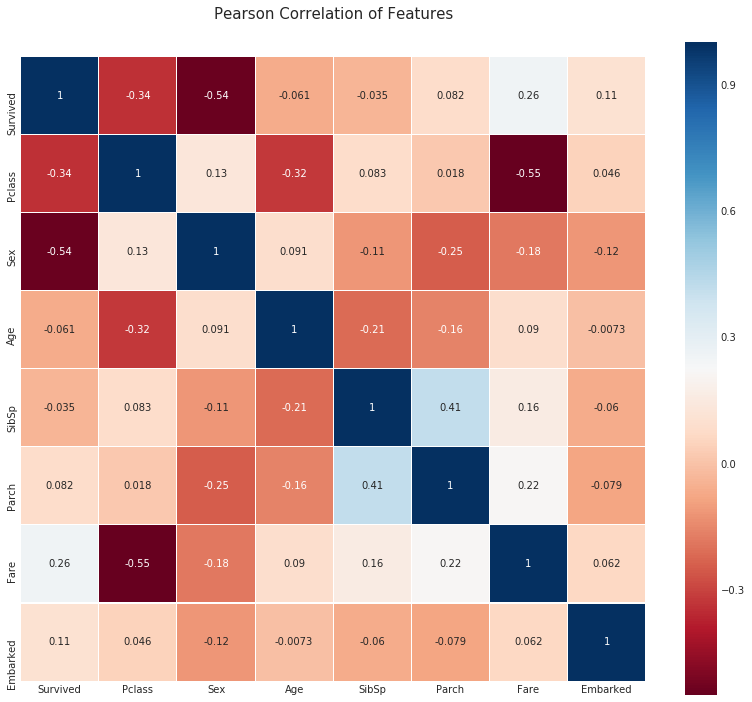

In [106]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

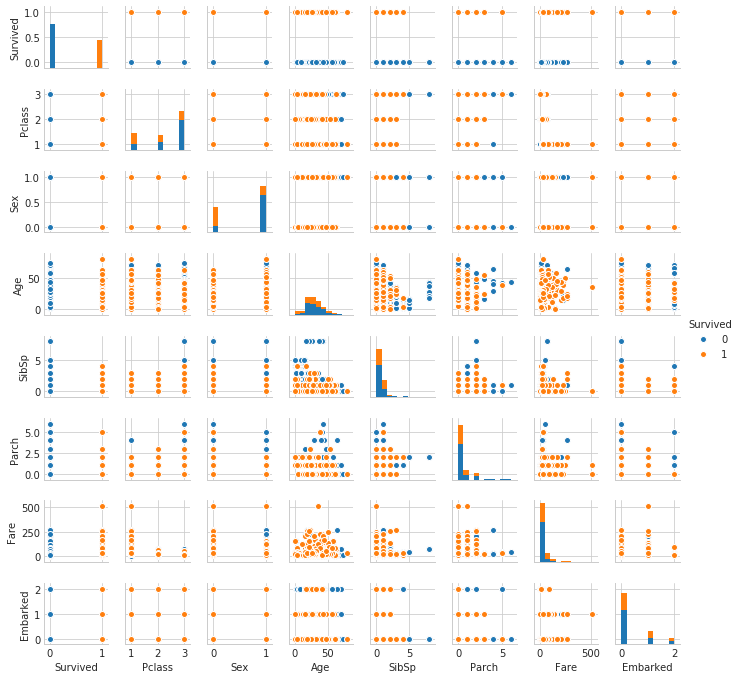

In [110]:
sns.pairplot(train, hue="Survived", size=1.2)

### Pclass
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

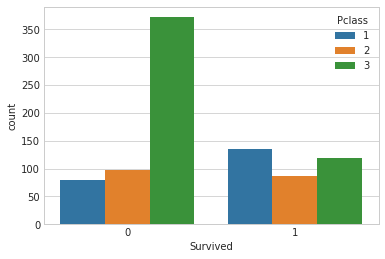

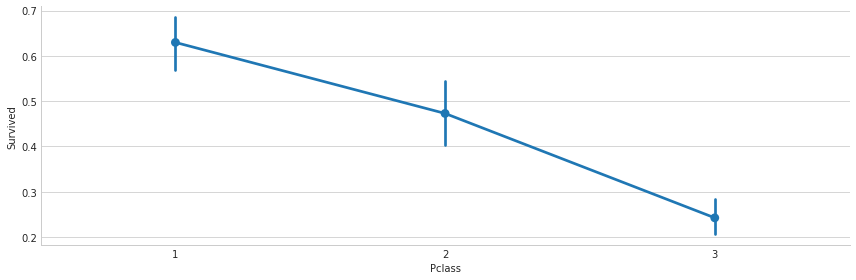

In [42]:
sns.countplot(x="Survived", hue="Pclass", data=train)
sns.factorplot("Pclass","Survived", data=train, size=4, aspect=3)

### Sex
0 = Female  
1 = Male

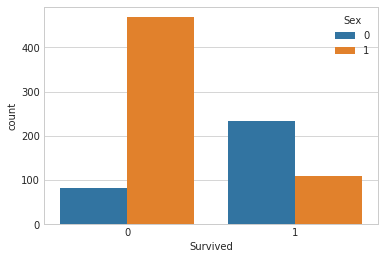

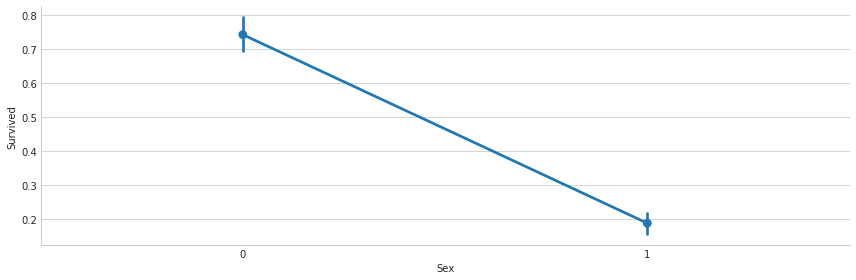

In [44]:
sns.countplot(x="Survived", hue="Sex", data=train)
sns.factorplot("Sex","Survived", data=train, size=4, aspect=3)

### Age
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

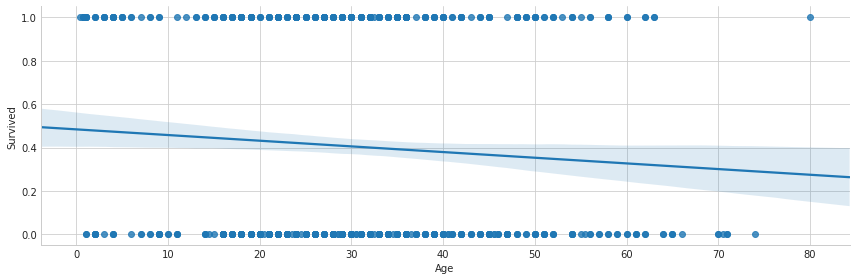

In [45]:
sns.lmplot("Age","Survived", data=train, size=4, aspect=3)

### SibSp
sibsp: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

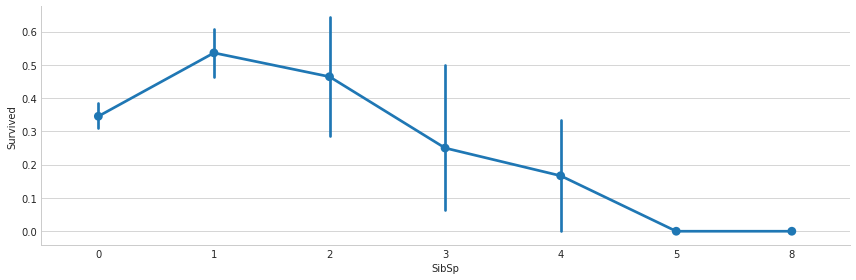

In [46]:
sns.factorplot("SibSp","Survived", data=train, size=4, aspect=3)

### Parch
parch: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  

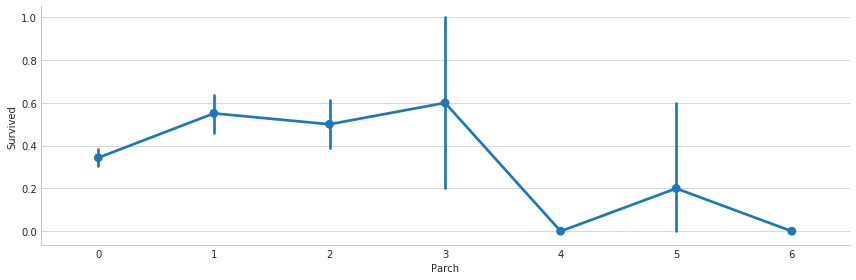

In [47]:
sns.factorplot("Parch","Survived", data=train, size=4, aspect=3)

### Fare

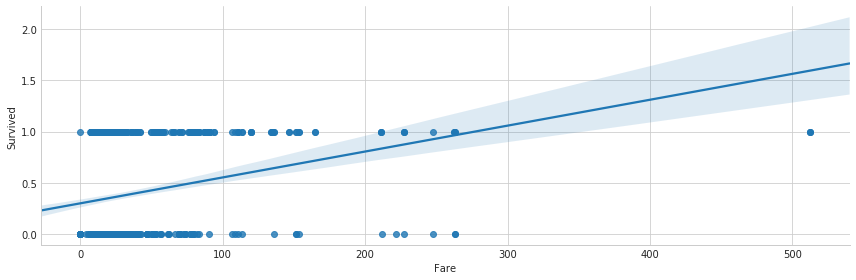

In [48]:
sns.lmplot("Fare","Survived", data=train, size=4, aspect=3)

### Embarked
0 = Southampton  
1 = Cherbourg  
2 = Queenstown

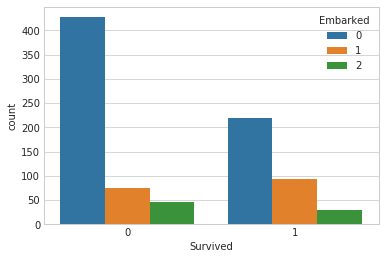

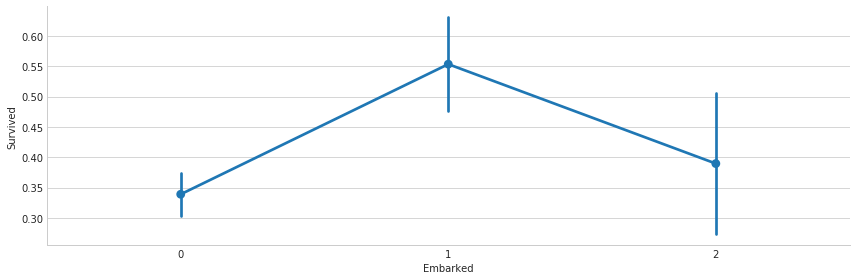

In [50]:
sns.countplot(x="Survived", hue="Embarked", data=train)
sns.factorplot("Embarked","Survived", data=train, size=4, aspect=3)

## Test datasets

In [89]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

## Helper class

In [84]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [90]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models

In [85]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [88]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [92]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').